# salpyter

[![Documentation Status](https://readthedocs.org/projects/salpyter/badge/?version=latest)](https://salpyter.readthedocs.io/en/latest/?badge=latest)

salpyter implements routines for computing and fitting to parametric forms for the stellar initial mass function, and performing Bayesians statistical inference of IMF parameters from data.

## Quickstart

In [1]:
%pylab
%matplotlib inline
import salpyter
np.random.seed(42)

Using matplotlib backend: module://matplotlib_inline.backend_inline
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


We can get the current list of implemented IMF functions via `IMF_LIST`:

In [2]:
salpyter.IMF_LIST

['powerlaw',
 'chabrier',
 'chabrier_smooth',
 'chabrier_smooth_lognormal',
 'chabrier_smooth_cutoff_lognormal',
 'powerlaw_bounds',
 'chabrier_bounds',
 'chabrier_smooth_bounds',
 'chabrier_smooth_lognormal_bounds',
 'chabrier_smooth_cutoff_lognormal_bounds']

Let's use the implemented `chabrier_smooth` model as an example: a lognormal that smoothly turns into a high-mass powerlaw with no cusp.

Note that the parameters of a given IMF should always be documented in the function's docstring.

In [3]:
model = "chabrier_smooth" # try out other models by changing the name here
imf_func = salpyter.get_imf_function(model)
?imf_func

Signature: imf_func(logm, params, logmmin=-inf, logmmax=4)
Docstring:
Chabrier IMF constrained to have a smooth break between the lognormal and power-law part

Parameters
----------
logm: array_like
    Array of log10(mass) values at which to evaluate the IMF
params: array_like
    Shape (3,) array of parameters: [log m_peak, log sigma, slope]
logmmin: float, optional
    Low-mass cutoff
logmmax: float, optional
    High-mass cutoff

Returns
-------
imf: array-like
    Value of the IMF normalized to integrate over logm
File:      ~/python_work/lib/python3.11/site-packages/salpyter/imfs.py
Type:      function

Sampling some masses from the model to act as our test data and plotting the result:

[None, None, Text(0, 0.5, 'N'), Text(0.5, 0, '$M\\,\\left(M_\\odot\\right)$')]

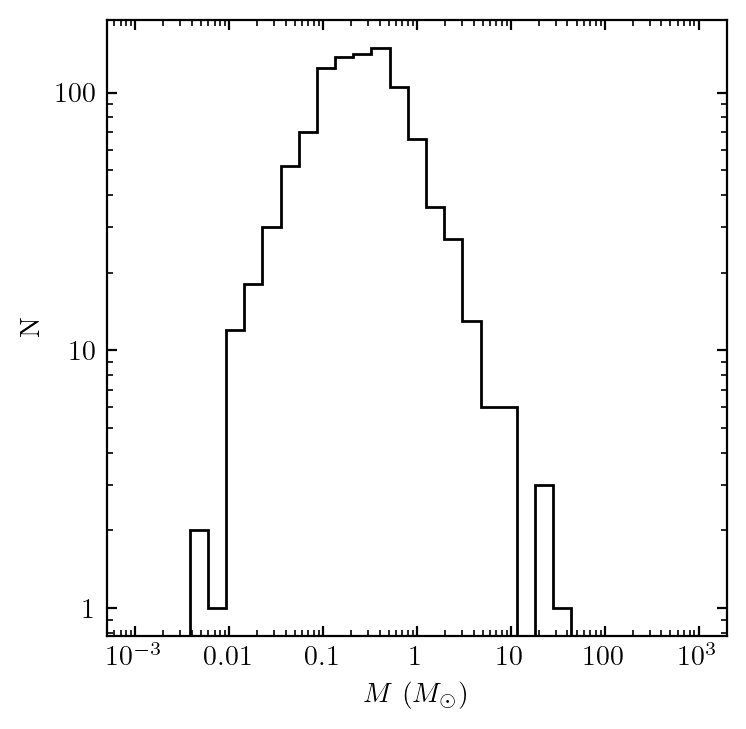

In [4]:
N = 10**3
masses = salpyter.imf_samples(N,model)

NUM_HIST_BINS = 31
mbins = np.logspace(-3, 3, 1 + NUM_HIST_BINS)
_, ax = plt.subplots(1, 1, figsize=(4, 4))
hist_args = dict(histtype='step',color='black')
ax.hist(masses, mbins, **hist_args)
ax.set(yscale="log",
            xscale="log",
            ylabel="N",
            xlabel=r"$M\,\left(M_\odot\right)$",
)


Now suppose we did not know the parameters of the IMF these data were sampled from *a priori*. To get the peak of the Bayesian likelihood distribution given the data, we can call `imf_mostlikely_params`, and plot that maximum-likelihood IMF on top of our histogram:

[None, None, Text(0, 0.5, 'N'), Text(0.5, 0, '$M\\,\\left(M_\\odot\\right)$')]

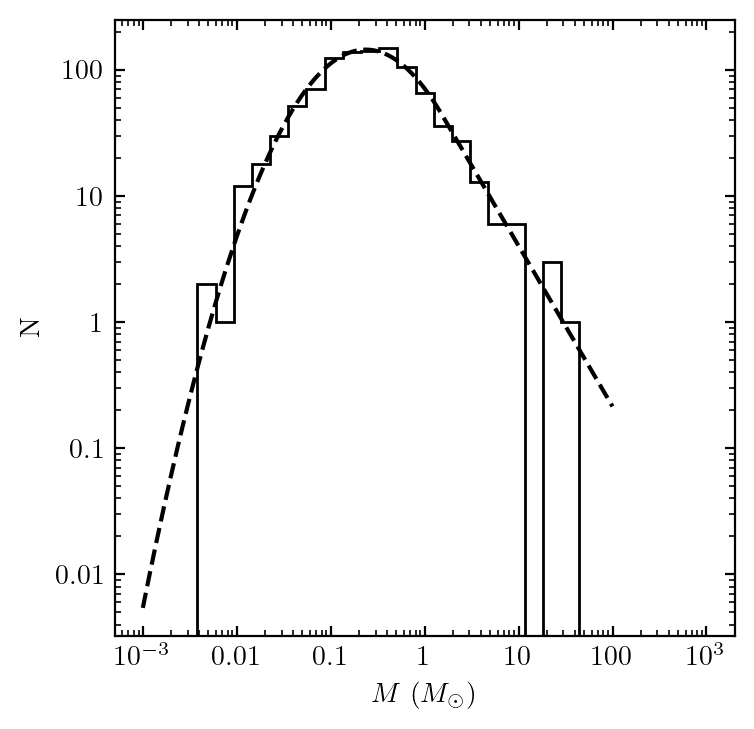

In [5]:
p0 = salpyter.imf_mostlikely_params(masses, model).x


_, ax = plt.subplots(1, 1, figsize=(4, 4))
mgrid = np.logspace(-3,2,10**4)
imf_values = imf_func(np.log10(mgrid),p0,logmmin=-3,logmmax=2)
imf_to_bins = np.log10(mbins.max() / mbins.min()) / (len(mbins) - 1) * len(masses) # convert from IMF value to expected bin counts
ax.plot(mgrid, imf_to_bins*imf_values,ls='dashed',color='black')
ax.hist(masses, mbins, histtype="step", color="black")
ax.set(yscale="log",
            xscale="log",
            ylabel="N",
            xlabel=r"$M\,\left(M_\odot\right)$",
)


For simple practical fitting purposes, this will typically provide a pretty good fit to the data; note, however, the maximum of the posterior likelihood is not invariant with respect to transformations in parameter space. For example, suppose instead of using the log of the characteristic mass $\log m_{\rm c}$ we used $m_{\rm c}$ as the parameter: the maximum-likelihood in that parameter space will be different. 

Thus, of greater interest for statistical inference is the overall distribution, which can be represented and summarized by Monte Carlo samples, and whose integration measure is invariant. Let's get some samples from the posterior likelihood distribution and plot them on top of our histogram to get a sense of the range of admissible IMFs this sample could have been drawn from:

[None,
 None,
 Text(0, 0.5, 'N'),
 Text(0.5, 0, '$M\\,\\left(M_\\odot\\right)$'),
 (0.5, 500)]

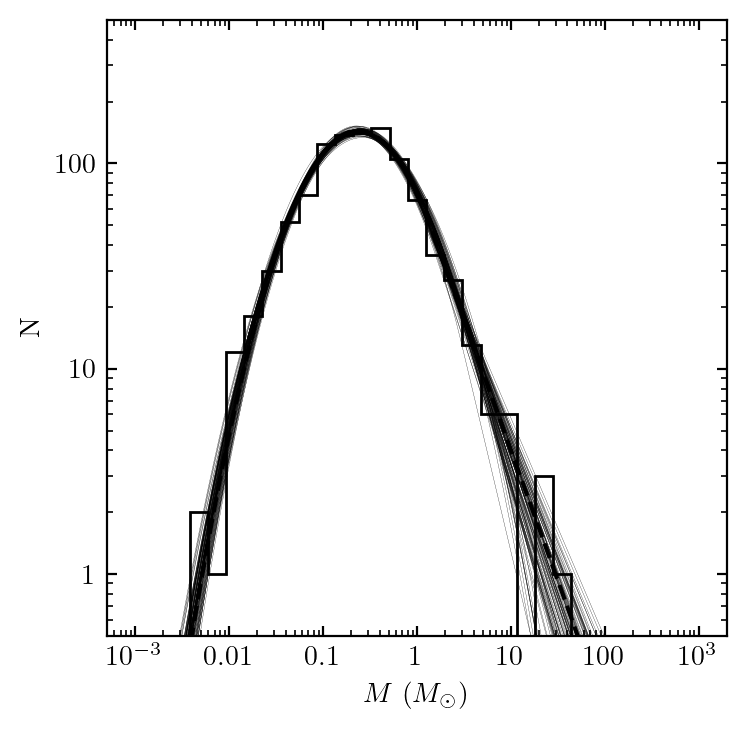

In [6]:
p0 = salpyter.imf_mostlikely_params(masses, model).x
samples = salpyter.imf_lnprob_samples(masses, model, p0,chainlength=10**4)

_, ax = plt.subplots(1, 1, figsize=(4, 4))
mgrid = np.logspace(-3,2,10**4)
imf_values = imf_func(np.log10(mgrid),p0,logmmin=-3,logmmax=2)
imf_to_bins = np.log10(mbins.max() / mbins.min()) / (len(mbins) - 1) * len(masses) # convert from IMF value to expected bin counts
ax.plot(mgrid, imf_to_bins*imf_values,ls='dashed',color='black')

for s in samples[::10]: #plotting imfs sampled from the likelihood distribution
    imf_values = imf_func(np.log10(mgrid),s,logmmin=-3,logmmax=2)
    ax.plot(mgrid, imf_to_bins*imf_values,color='black',lw=0.1)

ax.hist(masses, mbins, histtype="step", color="black")
ax.set(yscale="log",
            xscale="log",
            ylabel="N",
            xlabel=r"$M\,\left(M_\odot\right)$",
            ylim=[0.5,500]
)

Note that we have not specified a prior distribution - implicitly, we are using flat priors, whose bounds can optionally be passed to the `bounds` argument of `imf_lnprob_samples`.

With our samples in hand, we can get the likelihood distribution of individual parameters. For example, here parameter index 2 is the IMF slope (where the Salpeter value would be -1.35). We can examine the constraints we have on the slope:

Text(0, 0.5, '$\\mathcal{P}(\\alpha)$')

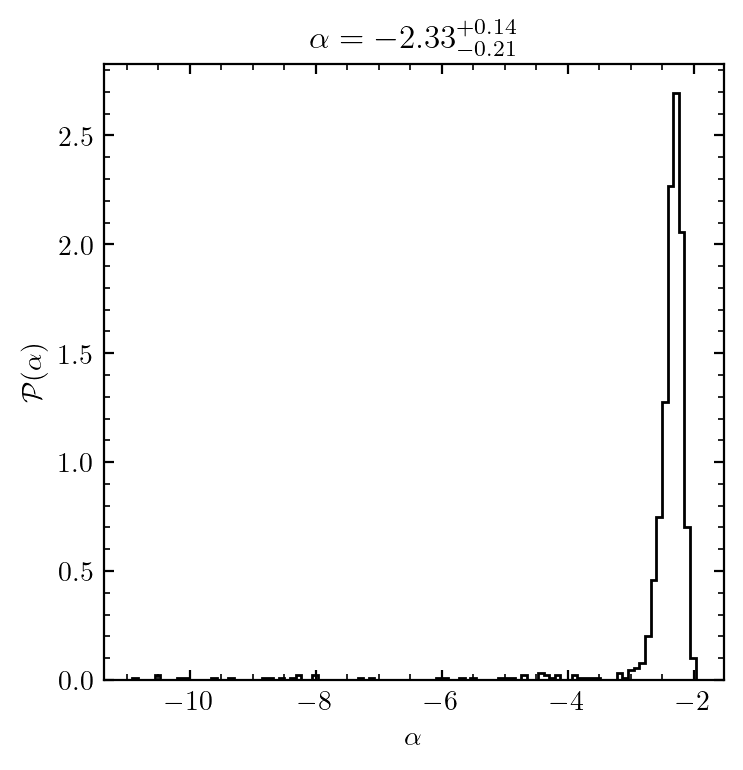

In [7]:
alpha = samples[:,2] - 1 # convention: alpha=-2.35 is Salpeter
plt.hist(alpha,100,**hist_args,density=True)
p = np.percentile(alpha,[16,50,84]) # median and +/- sigma percentiles
plt.title(r"$\alpha = %3.3g^{+%3.2g}_{-%3.3g}$"%(p[1],p[2]-p[1],p[1]-p[0]))
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\mathcal{P}(\alpha)$")